In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [53]:
df = pd.read_csv("data/house_price.csv")

In [54]:
df.head()

,price,baths,bedrooms,Area Category
0,10000000,2.0,2.0,0-5 Marla
1,6900000,3.0,3.0,5-10 Marla
2,16500000,6.0,5.0,5-10 Marla
3,43500000,4.0,4.0,1-5 Kanal
4,7000000,3.0,3.0,5-10 Marla


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929 entries, 0 to 1928
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          1929 non-null   int64  
 1   baths          1921 non-null   float64
 2   bedrooms       1925 non-null   float64
 3   Area Category  1920 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 60.4+ KB


In [56]:
df.isna().sum()

price            0
baths            8
bedrooms         4
Area Category    9
dtype: int64

In [57]:
df.duplicated().sum()

np.int64(480)

In [58]:
areas = df["Area Category"].unique()
areas = areas[pd.notna(areas)]

In [59]:
areas

array(['0-5 Marla', '5-10 Marla', '1-5 Kanal', '10-15 Marla',
       '5-10 Kanal', '15-20 Marla', '15-20 Kanal'], dtype=object)

In [60]:
type(areas)

numpy.ndarray

In [61]:
areas = sorted(areas, key=lambda x: x[-1])

In [62]:
areas

['0-5 Marla',
 '5-10 Marla',
 '10-15 Marla',
 '15-20 Marla',
 '1-5 Kanal',
 '5-10 Kanal',
 '15-20 Kanal']

In [63]:
X, y = df.drop(columns=["price"]), df["price"]

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [65]:
print(
    f"X_train{X_train.shape}\nX_test{X_test.shape}\ny_train{y_train.shape}\ny_test{y_test.shape}"
)

X_train(1543, 3)
X_test(386, 3)
y_train(1543,)
y_test(386,)


In [66]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer

In [67]:
from sklearn.base import TransformerMixin


class ArrayToDataFrame(TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names)


def round_transform(X):
    return np.round(X)


# Ordinal pipeline
ordinal_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder()),
    ]
)

In [68]:
def round_transform(X):
    return np.round(X)


ordinal_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(categories=[areas])),
    ]
)

numerical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("rounder", FunctionTransformer(round_transform)),
        ("scaler", StandardScaler()),
    ]
)

In [69]:
from sklearn.compose import ColumnTransformer

preprocessing_pipeline = ColumnTransformer(
    [
        ("ordinal_preprocessor", ordinal_pipeline, ["Area Category"]),
        ("numerical_preprocessor", numerical_pipeline, ["baths", "bedrooms"]),
    ]
)


output_columns = ["Area Category", "baths", "bedrooms"]

full_pipeline = Pipeline(
    [
        ("preprocessor", preprocessing_pipeline),
        ("to_dataframe", ArrayToDataFrame(output_columns)),
    ]
)

In [76]:
preprocessed_features = full_pipeline.fit_transform(X_train)
preprocessed_features.describe().round(3)

,Area Category,baths,bedrooms
count,1543.000,1543.000,1543.000
mean,1.663,0.000,-0.000
std,1.542,1.000,1.000
min,0.000,-1.590,-1.907
25%,0.000,-0.734,-0.354
50%,1.000,0.122,-0.354
75%,4.000,0.550,0.681
max,6.000,2.691,4.304


In [71]:
from sklearn.linear_model import LinearRegression

final_pipe = Pipeline(
    [("preprocessor", preprocessing_pipeline), ("cfg", LinearRegression())]
)

In [72]:
final_pipe.fit(X_train, y_train)
score = final_pipe.score(X_test, y_test)

print(score)

0.22910853397814512


In [73]:
predictions = final_pipe.predict(X_train)
predictions

array([17153979.19721957, 18125826.48918392, 17496560.590002  , ...,
         860537.11221823, 37789185.6156266 , -3138645.82840503])

In [74]:
df = pd.DataFrame(
    {"Index": np.arange(len(predictions)), "Actual": y_train, "Predicted": predictions}
)

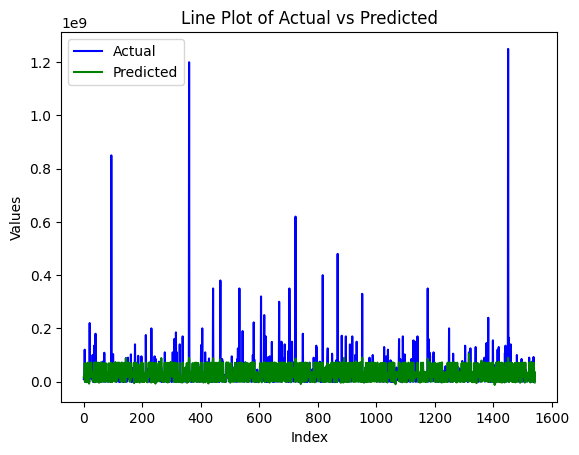

In [75]:
sns.lineplot(x="Index", y="Actual", data=df, label="Actual", color="blue")
sns.lineplot(x="Index", y="Predicted", data=df, label="Predicted", color="green")

plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Line Plot of Actual vs Predicted")
plt.legend()
plt.show()